# Experiment on the Math PhD Exchange

This data set comes from the article ["Eigenvector-Based Centrality Measures for Temporal Networks
"](https://arxiv.org/abs/1507.01266) by Taylor, Myers, Clauset, Porter, and Mucha. What is tracked here is **not** hiring data. In each year, the authors scraped the number of PhDs produced at institution $j$ whose advisor received a PhD at institution $i$. This is arguably a proxy for hiring data, but there are several issues. For example, if a scholar is hired at institution $j$, they won't actually appear in this data set until their first PhD student graduates, which would presumably be 4-7 years after their hiring. 

Since our model is obviously mis-specified on this data, we should proceed with caution. 

In [1]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('data/PhD Exchange Network Data/PhD_exchange.txt', 
            delim_whitespace=True, 
            names = ('endorsed', 'endorser', 'k', 'year'))

with open('data/PhD Exchange Network Data/school_names.txt') as f:
    snames = f.read().splitlines()
# df[['endorsed', 'k']].groupby('endorsed').sum()

In [3]:
top_deps = df[['endorsed', 'k']].groupby('endorsed').sum().nlargest(70,'k') # 20 seemed to give reasonable results
top_deps = np.array(top_deps.index)
df = df[df['endorsed'].isin(top_deps)]
df = df[df['endorser'].isin(top_deps)]

lookup = {top_deps[i] : i + 1000 for i in range(len(top_deps))}
df = df.replace({'endorsed' : lookup, 'endorser' : lookup})
df.endorsed = df.endorsed - 1000
df.endorser = df.endorser - 1000

In [4]:
# primary data transformation: here be bugs??

n = max(df.endorser.max()+1, df.endorsed.max()+1)

t_min = df.year.min()

T_ = np.zeros((df.year.max() - df.year.min()+1, n, n))
for i in df.index:
    T_[df.year[i] - t_min, df.endorsed[i], df.endorser[i]] += df.k[i] 
T = np.cumsum(T_, axis = 0)

In [5]:
T[-1].sum(axis = 1)

array([698., 618., 564., 517., 479., 245., 281., 259., 239., 215., 186.,
       188., 174., 159., 163., 168., 123., 127., 114., 125., 132., 105.,
        92.,  66.,  65.,  59.,  49.,  65.,  63.,  46.,  42.,  42.,  33.,
        31.,  39.,  39.,  33.,  35.,  25.,  22.,  34.,  30.,  35.,  27.,
        32.,  27.,  23.,  25.,  26.,  22.,  20.,  22.,  23.,  21.,  27.,
        30.,  22.,  14.,  17.,  20.,  15.,  12.,  13.,  13.,  16.,  12.,
         8.,  10.,  15.,  15.])

In [6]:
# Let's start t_start years in
t_start = 20

A0 = T[t_start,:,:]
A0 = A0 / A0.sum() # normalized

# mean hiring per year after t_start: 
v = T[t_start:,:,:].sum(axis = (1,2))
A0 = A0*((v[-1] - v[0]) / len(v))

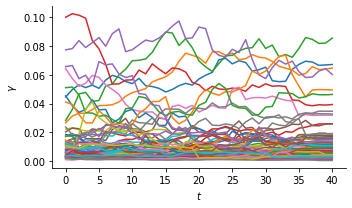

In [14]:
T_ = T[t_start:,:,:]

lam = .86
n_rounds = T_.shape[0]
beta = 2.36

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T_, lam, A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], beta)
    
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)

for l in range(n):
    ax.plot(GAMMA[:,l])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel = r'$t$',
       ylabel = r'$\gamma$')

plt.tight_layout()

In [17]:
np.log(.5) / np.log(lam)

4.59576912880888

In [18]:
maxes = GAMMA.argmax(axis = 1)
maxes
# for i in maxes:
#     print(snames[i+1])

array([ 3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  4,
        4,  4,  4,  4,  4,  4,  1,  1,  4,  2,  4,  2,  2,  2,  2, 11,  2,
        2,  2,  2,  2,  2,  2,  2])

In [19]:
lookup

{52: 1000,
 131: 1001,
 90: 1002,
 78: 1003,
 39: 1004,
 202: 1005,
 113: 1006,
 25: 1007,
 165: 1008,
 153: 1009,
 64: 1010,
 218: 1011,
 13: 1012,
 134: 1013,
 24: 1014,
 14: 1015,
 79: 1016,
 11: 1017,
 192: 1018,
 166: 1019,
 201: 1020,
 116: 1021,
 161: 1022,
 181: 1023,
 45: 1024,
 69: 1025,
 110: 1026,
 108: 1027,
 81: 1028,
 44: 1029,
 84: 1030,
 136: 1031,
 55: 1032,
 111: 1033,
 65: 1034,
 198: 1035,
 94: 1036,
 37: 1037,
 154: 1038,
 106: 1039,
 122: 1040,
 200: 1041,
 28: 1042,
 143: 1043,
 188: 1044,
 119: 1045,
 109: 1046,
 162: 1047,
 190: 1048,
 155: 1049,
 180: 1050,
 129: 1051,
 147: 1052,
 182: 1053,
 8: 1054,
 211: 1055,
 96: 1056,
 168: 1057,
 148: 1058,
 179: 1059,
 172: 1060,
 98: 1061,
 209: 1062,
 212: 1063,
 15: 1064,
 132: 1065,
 23: 1066,
 4: 1067,
 76: 1068,
 80: 1069}

In [20]:
lam_grid = 51 # resolution in $\lambda$
b_grid = 51   # resolution in $\beta$

LAMBDA = np.linspace(.5, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(1, 5, b_grid)            # beta values at which to evaluate

# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

M = estimation.likelihood_surface(T_, LAMBDA, BETA, A0) 

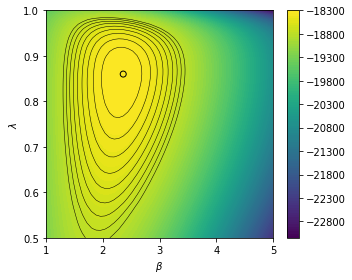

In [21]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax.contourf(xg, yg, M, levels = 100)
ax.contour(xg, yg, M, 
           levels = np.linspace(M.max()-500, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

#     ax.scatter(beta, lam, color = 'black')

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

plt.tight_layout()

In [22]:
ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

In [23]:
beta_hat, lambda_hat

(2.3600000000000003, 0.86)